# COMPAS Data EDA

### Cyrus Rody-Ramazani, Megan Sindhi, and Bo Anderson

This is my brief but also took way too long EDA for the COMPAS data

Here I'm just filtering out the information I didn't think was too relevant

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")
y= pd.read_csv("compas-scores.csv")

colremove = ['c_jail_in', 'c_jail_out','r_jail_in', "r_case_number", "v_type_of_assessment", "type_of_assessment", "compas_screening_date", "v_screening_date", "dob", "name", "num_r_cases", "c_case_number", "c_days_from_compas", "c_charge_degree", "c_charge_desc", "r_charge_desc", 'r_jail_out', "vr_charge_degree",	"num_vr_cases", "vr_case_number", "vr_offense_date", "vr_charge_desc", 'days_b_screening_arrest',  'c_offense_date', 'c_arrest_date', 'screening_date', 'r_offense_date', 'r_charge_degree', 'r_days_from_arrest']

Compas = y.drop(colremove, axis =1)

Compas.head()

,id,first,last,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,v_score_text,decile_score.1,score_text
0,1,miguel,hernandez,Male,69,Greater than 45,Other,0,1,0,0,0,0,0,1,Low,1,Low
1,2,michael,ryan,Male,31,25 - 45,Caucasian,0,5,0,0,0,-1,0,2,Low,5,Medium
2,3,kevon,dixon,Male,34,25 - 45,African-American,0,3,0,0,0,1,1,1,Low,3,Low
3,4,ed,philo,Male,24,Less than 25,African-American,0,4,0,1,4,1,0,3,Low,4,Low
4,5,marcu,brown,Male,23,Less than 25,African-American,0,8,1,0,1,0,0,6,Medium,8,High


Now I'm going about making a data set that filters by race, sex, and the measured risk of recidivism (score_text)

In [93]:
yn = Compas.groupby(["race", "sex", "score_text"])
y4 = yn[["id"]].count()
y4.head(10)

id
race             sex    score_text      
African-American Female High         209
                        Low          567
                        Medium       340
                 Male   High        1414
                        Low         1912
                        Medium      1365
Asian            Female Low            6
                        Medium         1
                 Male   High           4
                        Low           38

I'm now adding in a way to determine the % of each of gender/race category that is in high, medium and low risk. First I'm creating an array that sums the total number of African American Women, African American Men, Asian women, etc.

In [94]:

Compas2 = [y4.loc["African-American", "id"].loc["Female"].sum(),
      y4.loc["African-American", "id"].loc["Male"].sum(),
      y4.loc["Asian", "id"].loc["Female"].sum(),
      y4.loc["Asian", "id"].loc["Male"].sum(),
      y4.loc["Caucasian", "id"].loc["Female"].sum(),
      y4.loc["Caucasian", "id"].loc["Male"].sum(),
      y4.loc["Hispanic", "id"].loc["Female"].sum(),
      y4.loc["Hispanic", "id"].loc["Male"].sum(),
      y4.loc["Native American", "id"].loc["Female"].sum(),
      y4.loc["Native American", "id"].loc["Male"].sum(),
      y4.loc["Other", "id"].loc["Female"].sum(),
      y4.loc["Other", "id"].loc["Male"].sum(),
     ]
Compas2

[1116, 4691, 7, 51, 965, 3112, 189, 911, 10, 30, 130, 530]

This is just me fixing the array I made before I add it a a column because one of the rows didn't have any data and the columns weren't the same length.

In [95]:
Compas3 = np.repeat(Compas2, 3)

rt = list(Compas3)

rt.pop(6)

7

Now I'm finally making the new column

In [96]:
y4['totals'] = rt

y4["% of gender/race category"] = round(y4["id"]/y4["totals"]*100, 1)
COMPAS2 = y4.drop("totals", axis =1)

COMPAS2.head(10)

id  % of gender/race category
race             sex    score_text                                 
African-American Female High         209                       18.7
                        Low          567                       50.8
                        Medium       340                       30.5
                 Male   High        1414                       30.1
                        Low         1912                       40.8
                        Medium      1365                       29.1
Asian            Female Low            6                       85.7
                        Medium         1                       14.3
                 Male   High           4                        7.8
                        Low           38                       74.5

Now I'm making a pivot table with the data, showing how overall African Americans are overrepresented in the High and Medium risk percentages.

In [97]:
COMPAS3 =COMPAS2.reset_index() 

COMPASPIVOT = COMPAS3.pivot_table(
    values = "% of gender/race category",
    index = 'race', 
    columns = 'score_text'
)

COMPASPIVOT

score_text,High,Low,Medium
race,,,
African-American,24.40,45.80,29.80
Asian,7.80,80.10,15.95
Caucasian,10.95,65.65,23.40
Hispanic,6.90,76.30,16.80
Native American,18.35,55.00,26.65
Other,3.85,80.85,15.25


Finally, I'm plotting this data in bar graphs split up by both race, and gender

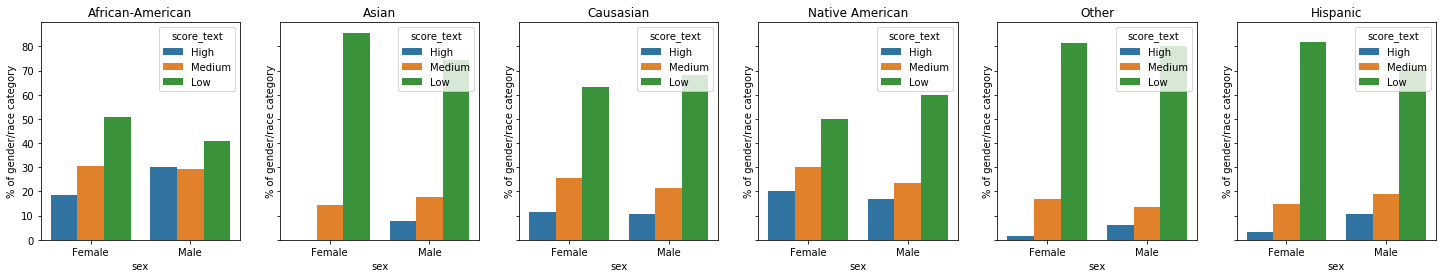

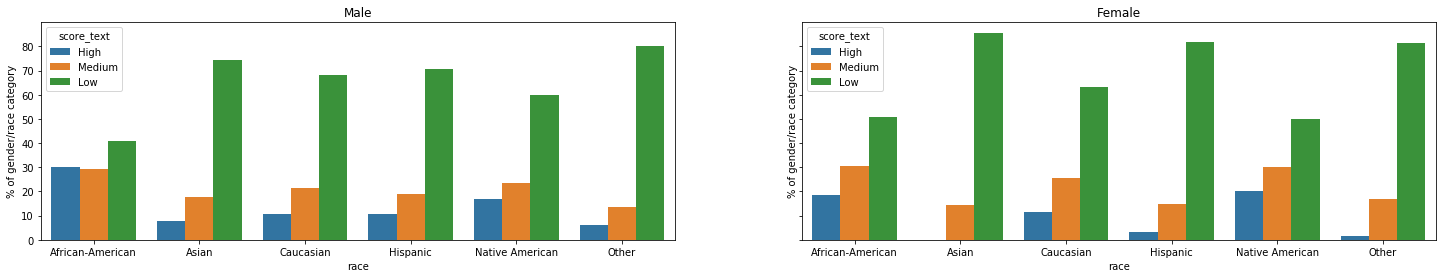

In [98]:
r1 = COMPAS3[(COMPAS3.race == "African-American")]
r2 = COMPAS3[(COMPAS3.race == "Asian")]
r3 = COMPAS3[(COMPAS3.race == "Caucasian")]
r4 = COMPAS3[(COMPAS3.race == "Native American")]
r5 = COMPAS3[(COMPAS3.race == "Other")]
r6 = COMPAS3[(COMPAS3.race == "Hispanic")]
r7 = COMPAS3[(COMPAS3.race == "Oriental")]
r8 = COMPAS3[(COMPAS3.race == "Arabic")]

m1 = COMPAS3[(COMPAS3.sex == "Male")]
m2 = COMPAS3[(COMPAS3.sex == "Female")]

import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 6, sharey=True, figsize=(25, 4))
rac1 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r1, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[0])).set_title("African-American")
rac2 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r2, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[1])).set_title("Asian")
rac3 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r3, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[2])).set_title("Causasian")
rac4 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r4, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[3])).set_title("Native American")
rac5 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r5, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[4])).set_title("Other")
rac6 = (sns.barplot(x= "sex" , y="% of gender/race category", data=r6, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[5])).set_title("Hispanic")

f, axes = plt.subplots(1, 2, sharey=True, figsize=(25, 4))
sex1 = (sns.barplot(x= "race" , y="% of gender/race category", data=m1, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[0])).set_title("Male")
sex2 = (sns.barplot(x= "race" , y="% of gender/race category", data=m2, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[1])).set_title("Female")



^Note how african american men are disproportionately identified as high risk for recidivism

I'm now rehasing the last barplot, this time showing data of how far away from the average percentages each subgroup is. For instance, %12,  of the data set is at a high risk of recidivism, 21% of medium, and 67% at low, and I'm comparing how each subgroup stacks up against this metric



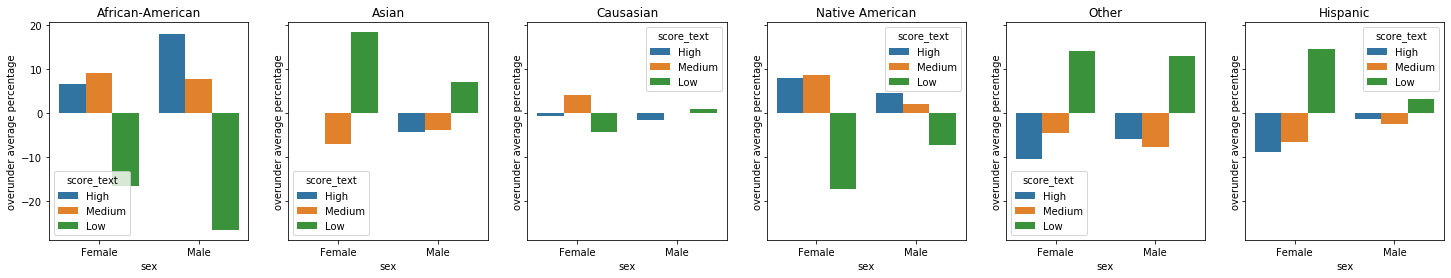

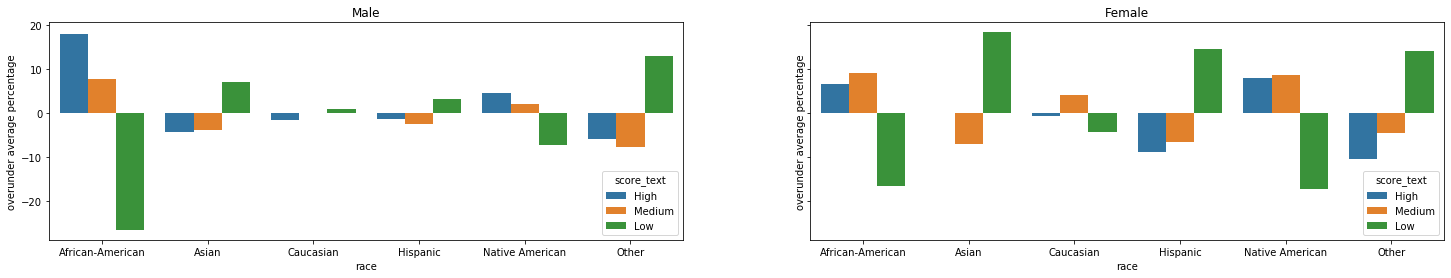

In [99]:
mean = [COMPASPIVOT.High.mean(),
        COMPASPIVOT.Low.mean(),
        COMPASPIVOT.Medium.mean(),]

Compas67 = mean * 12

r67 = list(Compas67)

r67.pop(6)

y4['meanscore'] = r67

y4["overunder average percentage"] = round(y4["% of gender/race category"]-y4["meanscore"], 1)

COMPAS7 = y4.drop(["meanscore"], axis =1)

COMPAS7 = COMPAS7.reset_index() 

d1 = COMPAS7[(COMPAS7.race == "African-American")]
d2 = COMPAS7[(COMPAS7.race == "Asian")]
d3 = COMPAS7[(COMPAS7.race == "Caucasian")]
d4 = COMPAS7[(COMPAS7.race == "Native American")]
d5 = COMPAS7[(COMPAS7.race == "Other")]
d6 = COMPAS7[(COMPAS7.race == "Hispanic")]
d7 = COMPAS7[(COMPAS7.race == "Oriental")]
d8 = COMPAS7[(COMPAS7.race == "Arabic")]

q1 = COMPAS7[(COMPAS7.sex == "Male")]
q2 = COMPAS7[(COMPAS7.sex == "Female")]

import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 6, sharey=True, figsize=(25, 4))
dc1 = (sns.barplot(x= "sex" , y="overunder average percentage", data=d1, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[0])).set_title("African-American")
dc2 = (sns.barplot(x= "sex" , y="overunder average percentage", data=d2, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[1])).set_title("Asian")
dc3 = (sns.barplot(x= "sex" , y="overunder average percentage", data=d3, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[2])).set_title("Causasian")
dc4 = (sns.barplot(x= "sex" , y="overunder average percentage", data=d4, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[3])).set_title("Native American")
dc5 = (sns.barplot(x= "sex" , y="overunder average percentage", data=d5, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[4])).set_title("Other")
dc6 = (sns.barplot(x= "sex" , y="overunder average percentage", data=d6, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[5])).set_title("Hispanic")

f, axes = plt.subplots(1, 2, sharey=True, figsize=(25, 4))
gd1 = (sns.barplot(x= "race" , y="overunder average percentage", data=q1, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[0])).set_title("Male")
gd2 = (sns.barplot(x= "race" , y="overunder average percentage", data=q2, hue = "score_text", hue_order = ["High", "Medium", "Low"], ax=axes[1])).set_title("Female")

Now I'm creating a heatmap of recidivism likelihood scores based upon the score given to men and women and age-range 

In [100]:
 yy = y.pivot_table(
    values = 'decile_score.1', 
    index = 'sex', 
    columns = 'age'
)
yy=yy.fillna(0)

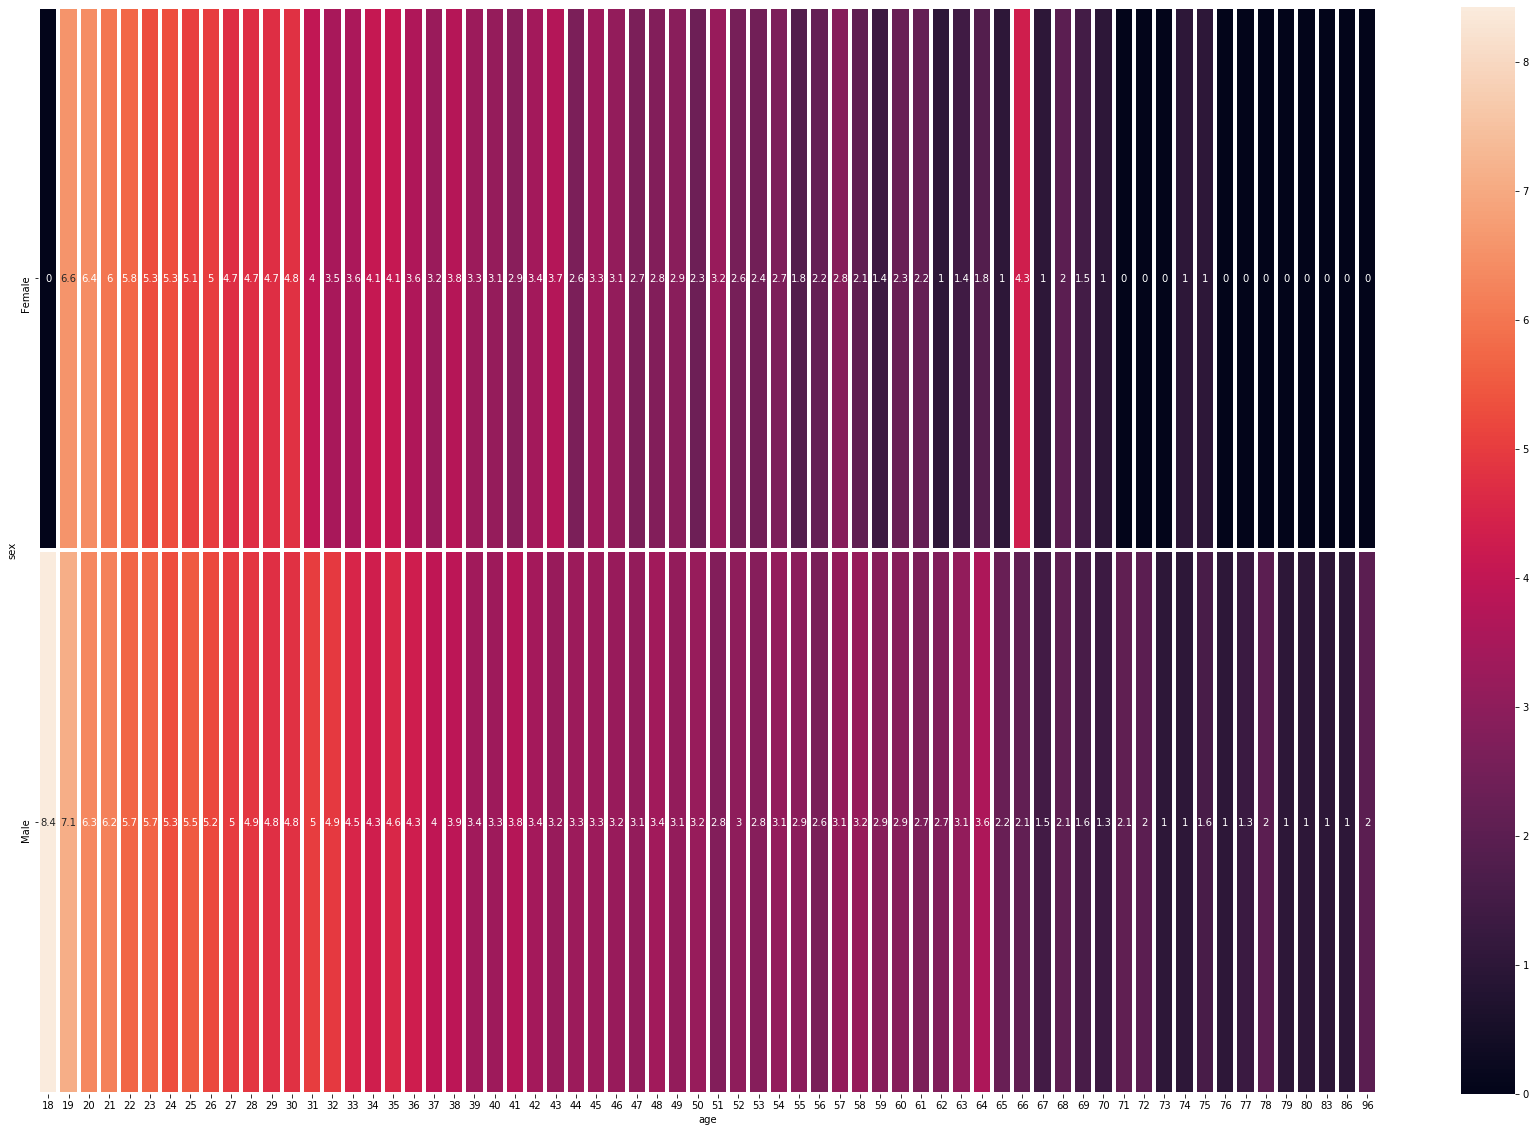

In [101]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(yy, annot=True, linewidths=3, ax=ax)

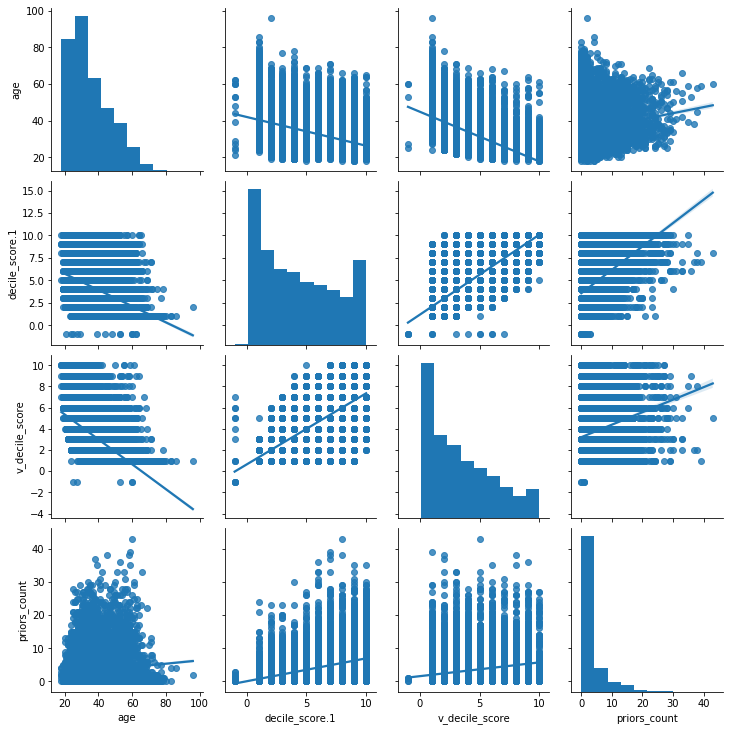

In [102]:
COMPAS1 = y[['age','decile_score.1', 'v_decile_score','priors_count']]
sns.pairplot(COMPAS1, kind='reg')

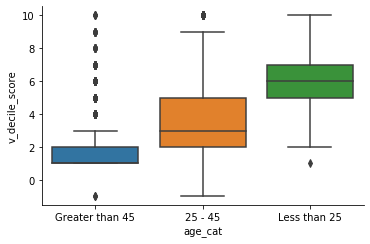

In [103]:
g = sns.catplot(x="age_cat", y="v_decile_score", 
                height=3.5, aspect=1.5,
                kind="box", legend=False, data=Compas)
##looking at distribution of violence decile scores in relation to age categories

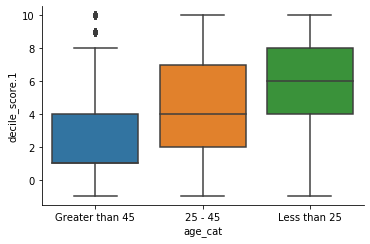

In [104]:
g = sns.catplot(x="age_cat", y="decile_score.1", 
                height=3.5, aspect=1.5,
                kind="box", legend=False, data=Compas)
##looking at distribution of recedivism decile scores in relation to age categories

In [105]:
pd.crosstab(Compas.race, Compas.v_score_text, normalize="index")
##examining the breakdown of score levels 
##significantly higher proportion of high risk for violence for african-american and native american

v_score_text,High,Low,Medium
race,,,
African-American,0.143349,0.561865,0.294786
Asian,0.034483,0.879310,0.086207
Caucasian,0.045321,0.792014,0.162665
Hispanic,0.061818,0.770909,0.167273
Native American,0.100000,0.675000,0.225000
Other,0.036309,0.822995,0.140696


In [106]:
pd.crosstab(Compas.juv_fel_count, Compas.v_score_text, normalize="columns")
##seeing proportion of junior felony counts in relation to their violence risk
##most people don't have more than one juvenile felony count, 
##although high risk have a much lower proportion of people with 0 felonies

v_score_text,High,Low,Medium
juv_fel_count,,,
0,0.838710,0.989207,0.941154
1,0.104839,0.007405,0.038981
2,0.030466,0.001757,0.011994
3,0.009857,0.001130,0.003748
4,0.006272,0.000377,0.002249
5,0.006272,0.000000,0.000375
6,0.000896,0.000000,0.000375
8,0.001792,0.000000,0.000000
9,0.000000,0.000000,0.000375


Possible ideas to explore looking for biases in the score and what factors change the score the most

In [107]:
#capitalized the names
Compas["first"] = Compas["first"].str.capitalize()
Compas["last"] = Compas["last"].str.capitalize()
Compas.head()

,id,first,last,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,v_decile_score,v_score_text,decile_score.1,score_text
0,1,Miguel,Hernandez,Male,69,Greater than 45,Other,0,1,0,0,0,0,0,1,Low,1,Low
1,2,Michael,Ryan,Male,31,25 - 45,Caucasian,0,5,0,0,0,-1,0,2,Low,5,Medium
2,3,Kevon,Dixon,Male,34,25 - 45,African-American,0,3,0,0,0,1,1,1,Low,3,Low
3,4,Ed,Philo,Male,24,Less than 25,African-American,0,4,0,1,4,1,0,3,Low,4,Low
4,5,Marcu,Brown,Male,23,Less than 25,African-American,0,8,1,0,1,0,0,6,Medium,8,High


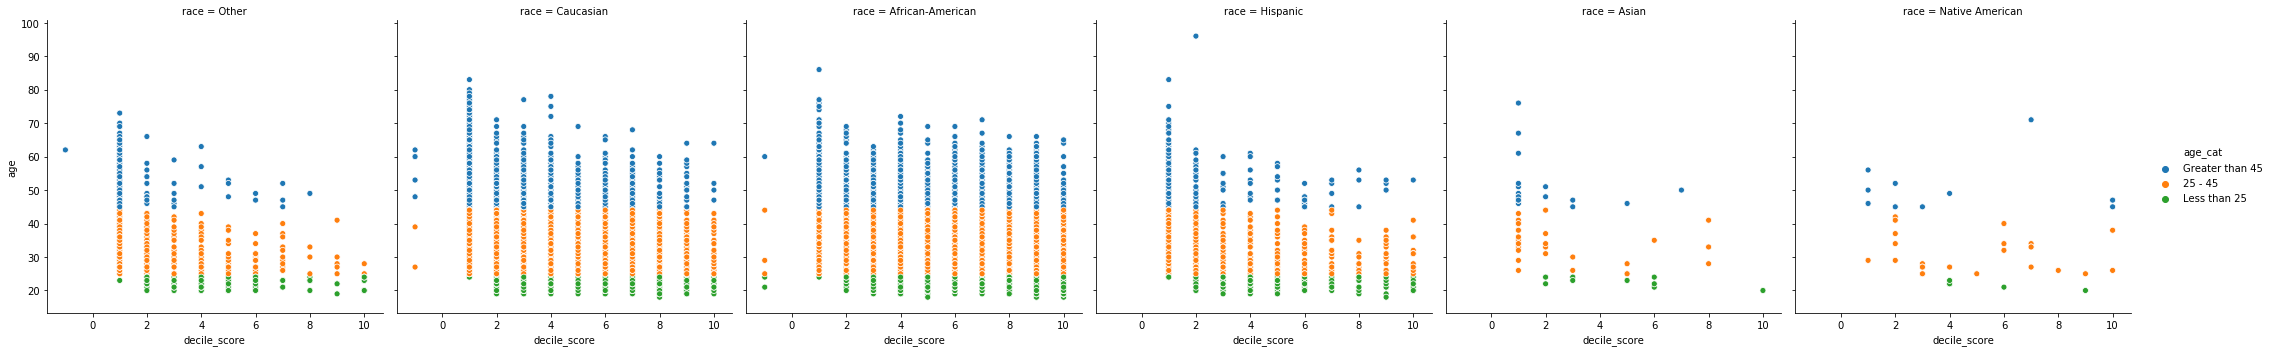

In [108]:
#Comparing decile score to age, and splitting data up by race
colremove = ['id', 'first', 'last', 'c_jail_in', 'c_jail_out','r_jail_in', "r_case_number", "v_type_of_assessment", "type_of_assessment", "compas_screening_date", "v_screening_date", "dob", "name", "num_r_cases", "c_case_number", "c_charge_degree", "c_charge_desc", "r_charge_desc", 'r_jail_out', "vr_charge_degree",	"num_vr_cases", "vr_case_number", "vr_offense_date", "vr_charge_desc", 'days_b_screening_arrest', 'v_screening_date', 'r_charge_degree', 'r_days_from_arrest']
Compas4 = y.drop(colremove, axis =1)
#sns.pairplot(Compas4)
c = sns.relplot(x="decile_score", y="age", col="race",
            hue="age_cat", data=Compas4)

Might be interesting to compare the decile score to the difference in time between when the individual is released from jail initially and, if they recidivise, when the individual is put in jail for their recidivism offense

In [112]:
Compas5 = y
Compas5.count()

id                         11757
name                       11757
first                      11757
last                       11757
compas_screening_date      11757
sex                        11757
dob                        11757
age                        11757
age_cat                    11757
race                       11757
juv_fel_count              11757
decile_score               11757
juv_misd_count             11757
juv_other_count            11757
priors_count               11757
days_b_screening_arrest    10577
c_jail_in                  10577
c_jail_out                 10577
c_case_number              11015
c_offense_date              9157
c_arrest_date               1858
c_days_from_compas         11015
c_charge_degree            11757
c_charge_desc              11008
is_recid                   11757
num_r_cases                    0
r_case_number               3703
r_charge_degree            11757
r_days_from_arrest          2460
r_offense_date              3703
r_charge_d

In [118]:
a = y[['c_offense_date']].dropna()
b = y[["c_arrest_date"]].dropna()
a['c_offense_date'] = pd.to_datetime(a['c_offense_date'], errors='coerce')
a['c_offense_year'] = a["c_offense_date"].dt.year
b['c_arrest_date'] = pd.to_datetime(b['c_arrest_date'], errors='coerce')
b['c_arrest_year'] = b["c_arrest_date"].dt.year

#convert types to ints so can perform math operations
a['c_offense_year'] = a['c_offense_year'].astype('int64')
b['c_arrest_year'] = b['c_arrest_year'].astype('int64')

copyOff = Compas5[['r_offense_date']].dropna()

a['r_offense_date'] = copyOff['r_offense_date']
b['r_offense_date'] = copyOff['r_offense_date']
a.dropna()
b.dropna()
a['r_offense_date'] = pd.to_datetime(a['r_offense_date'], errors='coerce')
b['r_offense_date'] = pd.to_datetime(b['r_offense_date'], errors='coerce')
a['r_offense_year'] = a['r_offense_date'].dt.year.astype('int64')
b['r_offense_year'] = b['r_offense_date'].dt.year.astype('int64')
a



ValueError: Cannot convert non-finite values (NA or inf) to integer